# Определение стоимости автомобилей

#### Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

#### Описание данных

Данные находятся в файле [`/datasets/autos.csv`](https://code.s3.yandex.net/datasets/autos.csv). 

#### Признаки

+ `DateCrawled` — дата скачивания анкеты из базы
+ `VehicleType` — тип автомобильного кузова
+ `RegistrationYear` — год регистрации автомобиля
+ `Gearbox` — тип коробки передач
+ `Power` — мощность (л. с.)
+ `Model` — модель автомобиля
+ `Kilometer` — пробег (км)
+ `RegistrationMonth` — месяц регистрации автомобиля
+ `FuelType` — тип топлива
+ `Brand` — марка автомобиля
+ `Repaired` — была машина в ремонте или нет
+ `DateCreated` — дата создания анкеты
+ `NumberOfPictures` — количество фотографий автомобиля
+ `PostalCode` — почтовый индекс владельца анкеты (пользователя)
+ `LastSeen` — дата последней активности пользователя

#### Целевой признак
+ `Price` — цена (евро)

#### План работы

1. Подготовка данных
    + Импорт библиотек
    + Загрузка данных из файла: /datasets/autos.csv.
    + Предобработка данных. 
        + Удаление неинформативных признаков
        + Заполненение пропущенных значений
        + Обработка аномалий в столбцах    
2. Подготовка выборки для обучения моделей
3. Обучение разных модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели подберём разные гиперпараметры
4. Анализ времени обучения, времени предсказания и качество моделей
5. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке

## 1. Подготовка данных

### 1.1. Установка пакетов

In [1]:
!pip install -U scikit-learn -q

### 1.2. Импорт библиотек

In [2]:
import lightgbm as lgb
import numpy as np
import pandas  as pd
pd.DataFrame.iteritems = pd.DataFrame.items
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import re
import seaborn as sns
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV
                                    )
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   StandardScaler
                                  )

try:
    import phik
except:
    !pip install phik -q
    import phik
    
try:
    from category_encoders import BinaryEncoder
except:
    !pip install category_encoders -q
    from category_encoders import BinaryEncoder

### 1.3. Загрузка данных

In [3]:
try:
    autos = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
autos.head()

Данные загружены, можно переходить к предобработке.

### 1.4. Предобработка данных

Переведём названия столбцов в нижний регистр, разделим слова подчёркиванием.

In [4]:
autos.info()

In [5]:
autos = autos.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower()) 
autos

#### Удалим неинформативные признаки (не влияющие на стоимость автомобиля)

+ `DateCrawled` — дата скачивания анкеты из базы
+ `RegistrationMonth` — месяц регистрации автомобиля
+ `DateCreated` — дата создания анкеты
+ `NumberOfPictures` — количество фотографий автомобиля
+ `PostalCode` — почтовый индекс владельца анкеты (пользователя)
+ `LastSeen` — дата последней активности пользователя

In [6]:
autos = autos.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
autos.info()

#### Удаление явных дубликатов

In [7]:
autos.duplicated().sum()

In [8]:
autos = autos.drop_duplicates()
autos.info(), autos.isna().sum()

#### Заполнение пропущенных значений после проверки на уникальность

In [9]:
print(sorted(autos['vehicle_type'].dropna().unique()))

In [10]:
print(sorted(autos['gearbox'].dropna().unique()))

In [11]:
print(sorted(autos['model'].dropna().unique()))

In [12]:
autos['fuel_type'] = autos['fuel_type'].replace('gasoline','petrol')
print(sorted(autos['fuel_type'].dropna().unique()))

In [13]:
print(sorted(autos['repaired'].dropna().unique()))

In [14]:
print(sorted(autos['brand'].dropna().unique()))

В столбцах не обнаружено дубликатов с ошибками в орфографии.

Для заполнения данных и отличия их от `other`:
+ заменим пропущенные значения в столбцах `vehicle_type`, `model`, `fuel_type` на `unknown`.
+ в столбце `gearbox` - тип коробки передач, значение может быть `auto` или  `manual`, но машина может продаваться без коробки, заменим пропуски на `unknown`.
+ в столбце `repaired` - была машина в ремонте или нет, значение может быть `no` или `yes`, но машина может продаваться в состоянии требующей ремонта, но не отремонтированной, заменим пропуски на `unknown`.

In [15]:
autos['vehicle_type'] = autos['vehicle_type'].fillna('unknown')
autos['model'] = autos['model'].fillna('unknown')
autos['fuel_type'] = autos['fuel_type'].fillna('unknown')
autos['gearbox'] = autos['gearbox'].fillna('unknown')
autos['repaired'] = autos['repaired'].fillna('unknown')

In [16]:
print(f'Мощность "brand" {len(autos.brand.unique())}')
print(f'Мощность "model" {len(autos.model.unique())}')
print(f'Мощность "vehicle_type" {len(autos.vehicle_type.unique())}')

In [17]:
autos.info()

In [18]:
autos.isna().sum()

+ Преобразовали названия столбцов в нижний регистр, разделили слова подчеркиванием
+ Удалили неинформативные признаки
    + `DateCrawled` — дата скачивания анкеты из базы
    + `RegistrationMonth` — месяц регистрации автомобиля
    + `DateCreated` — дата создания анкеты
    + `NumberOfPictures` — количество фотографий автомобиля
    + `PostalCode` — почтовый индекс владельца анкеты (пользователя)
    + `LastSeen` — дата последней активности пользователя
+ Удалили 45040 явных дубликатов
+ Заполнили пропущенные значения
    + заменили пропущенные значения в столбцах `vehicle_type`, `model`, `fuel_type` на `unknown`.
    + в столбце `gearbox` - тип коробки передач, значение может быть `auto` или  `manual`, но машина может продаваться без коробки, заменили пропуски на `unknown`.
    + в столбце `repaired` - была машина в ремонте или нет, значение может быть `no` или `yes`, но машина может продаваться в состоянии требующей ремонта, но не отремонтированной, заменили пропуски на `unknown`.

### 1.5. Исследовательский анализ данных

In [19]:
autos.describe()

#### Анализ `price` - цена (евро)

Цена автомобиля не бывает равной нулю, вероятно при сборе данных были объявления без указанной цены. Удалим такие строки из данных, выбросы более полуторного интервала оставим.

In [20]:
def f_hist_box_1(hb1, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[hb1], orient="h", ax=ax_box)
    plt.hist([hb1], 
             bins=bins, range=(hb1.min(), hb1.max()), label=hb1.name)
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

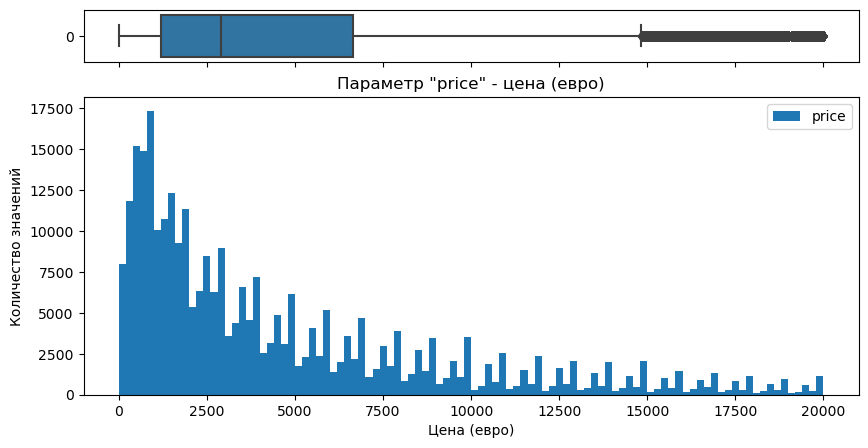

In [21]:
autos = autos[autos['price'] != 0]
f_hist_box_1(
    hb1=autos['price'],
    bins=100,   
    title='Параметр "price" - цена (евро)',
    xlabel='Цена (евро)',
    ylabel='Количество значений'
)

#### Анализ `registration_year` - год регистрации автомобиля

Дата регистрации автомобиля не может быть больше текущего года, а коллекционеры старинных автомобилей маловероятно будут узнавать цену на сайте и т.к. их стоимость велика ограничимся 1960 годом, автомобили такого года выпуска ещё встречаются на дорогах.

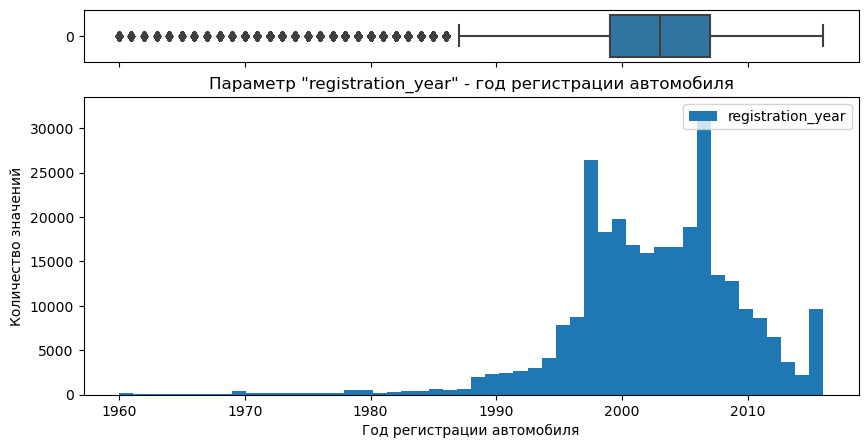

In [22]:
autos = autos[(autos['registration_year'] >= 1960) & (autos['registration_year'] <= 2016)]
f_hist_box_1(
    hb1=autos['registration_year'],
    bins=50,   
    title='Параметр "registration_year" - год регистрации автомобиля',
    xlabel='Год регистрации автомобиля',
    ylabel='Количество значений'
)

#### Анализ `kilometer` - пробег (км)

Здесь значения выглядят правдоподобно, оставим как есть.

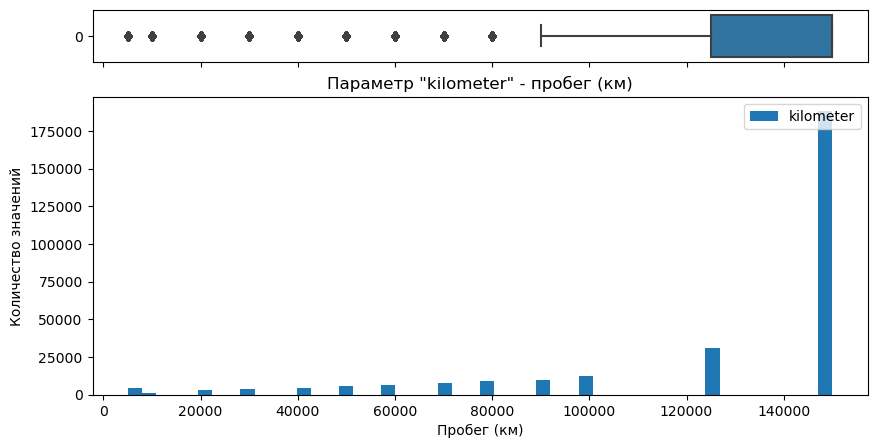

In [23]:
f_hist_box_1(
    hb1=autos['kilometer'],
    bins=50,   
    title='Параметр "kilometer" - пробег (км)',
    xlabel='Пробег (км)',
    ylabel='Количество значений'
)

#### Анализ `power` - мощность (л. с.)

Мощность автомобилей в настоящее время редко превышает 500 л.с., откорректируем это. Нулевые значения оставим,т.к. машины могут продаваться без двигателя, да и их значение в данных велико.

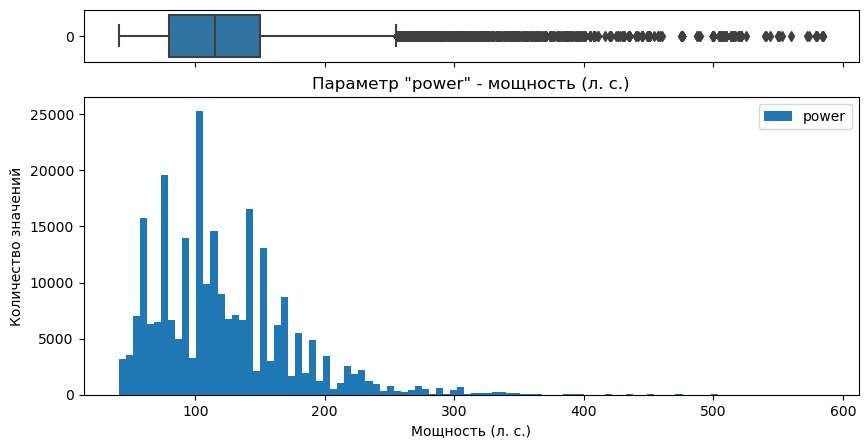

In [24]:
#autos = autos[(autos['power'] != 0) & (autos['power'] < 500)]
autos = autos[(autos['power'] > 40) & (autos['power'] < 600)]
f_hist_box_1(
    hb1=autos['power'],
    bins=100,   
    title='Параметр "power" - мощность (л. с.)',
    xlabel='Мощность (л. с.)',
    ylabel='Количество значений'
)

In [25]:
autos.describe(include='object')

+ В данных обнаружено большое количество выбросов.
+ Исключены строки по параметру "price" - цена (евро) с нулевым значением.
+ Исключены строки по параметру "registration_year" - год регистрации автомобиля ранее 1960 года и более текущего года
+ Исключены строки по параметру "power" - мощность (л. с.) со значением до 40 л.с. и более 600 л.с.

### 1.6. Корреляционный анализ данных

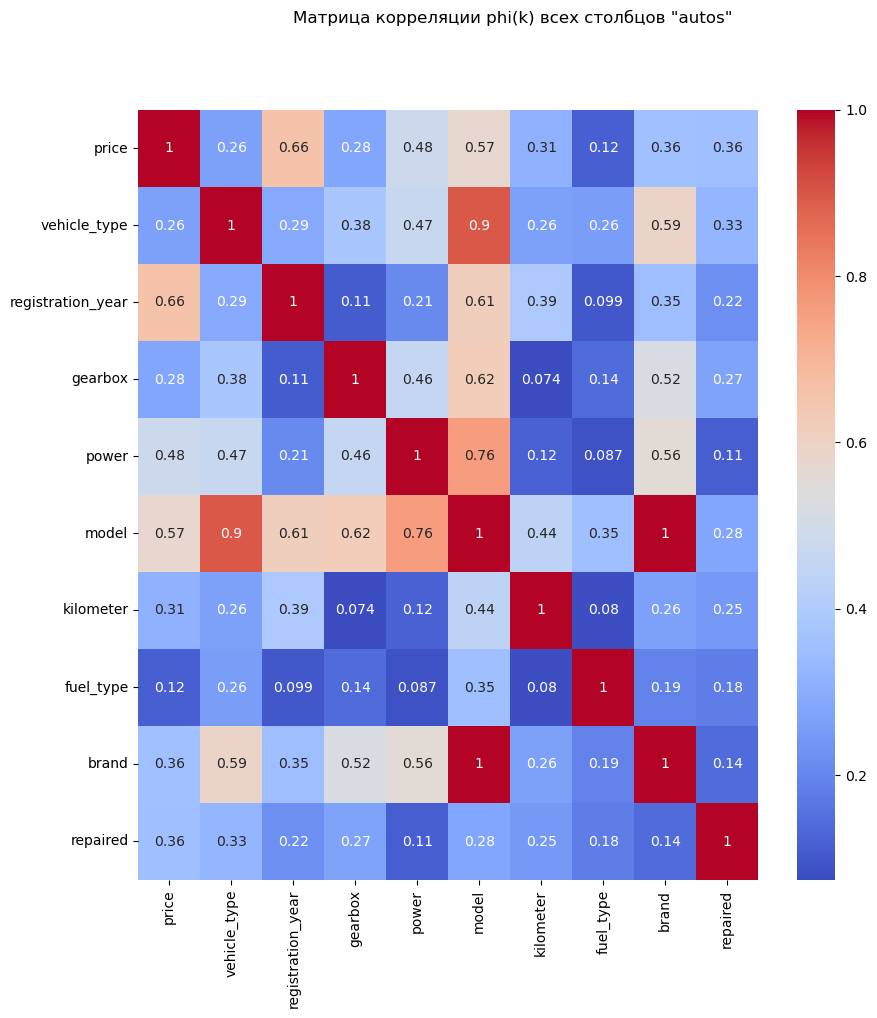

In [26]:
interval_cols = ['price',
                 'registration_year',
                 'power',
                 'kilometer'
                ]
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "autos"')
sns.heatmap(autos.phik_matrix(interval_cols = interval_cols), annot=True, cmap='coolwarm');

Прослеживается значительная зависимость цены автомобиля `price` от года регистрации автомобиля `registration_year` phi(k) = 0.66 и модели автомобиля `model` phi(k) = 0.57, влияние других параметров незначительно.

Прослеживается прямая зависимость между брендом автомобиля `brand` и моделью автомобиля `model` phi(k) = 1 для устранения мультиколлениарности объеденим стобец в один. 

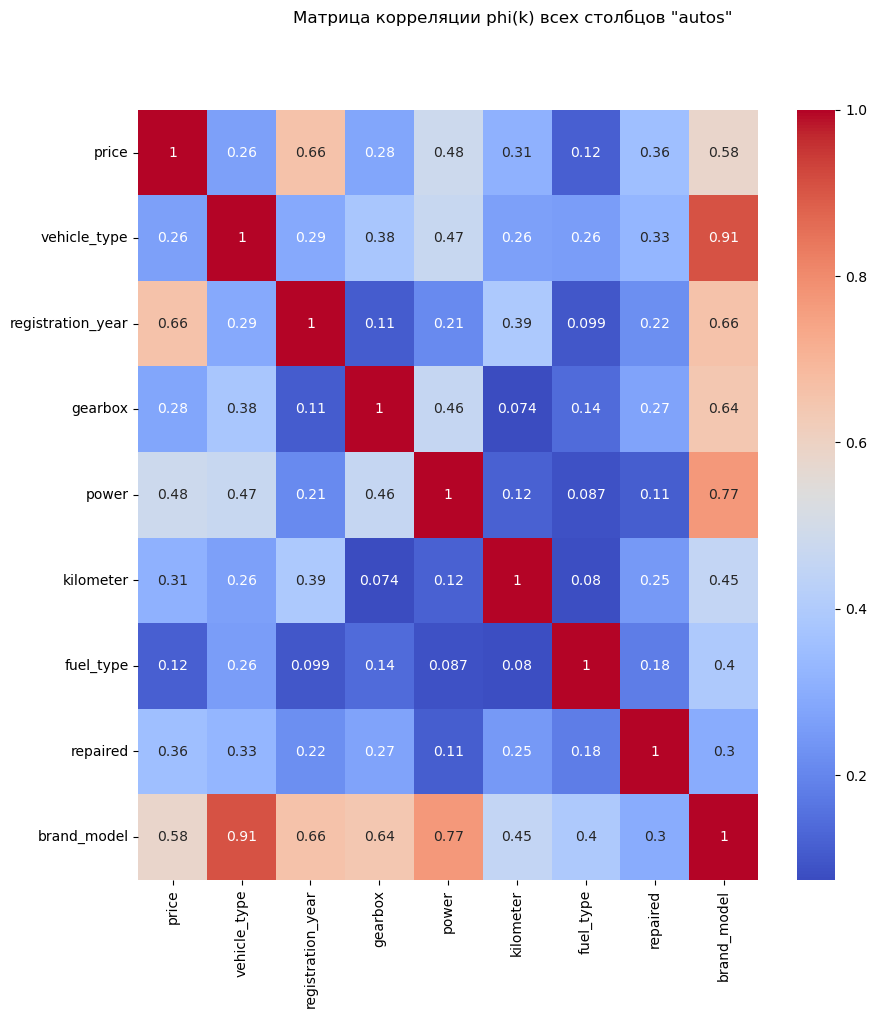

In [27]:
autos['brand_model'] = autos['brand'] + '_' + autos['model']
autos = autos.drop(columns=['brand', 'model'])
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "autos"')
sns.heatmap(autos.phik_matrix(interval_cols = interval_cols), annot=True, cmap='coolwarm');

Прослеживается прямая зависимость между брендом_моделью brand_model и типом кузова vehicle_type автомобиля model phi(k) = 0.91 для устранения мультиколлениарности объеденим стобец в один.

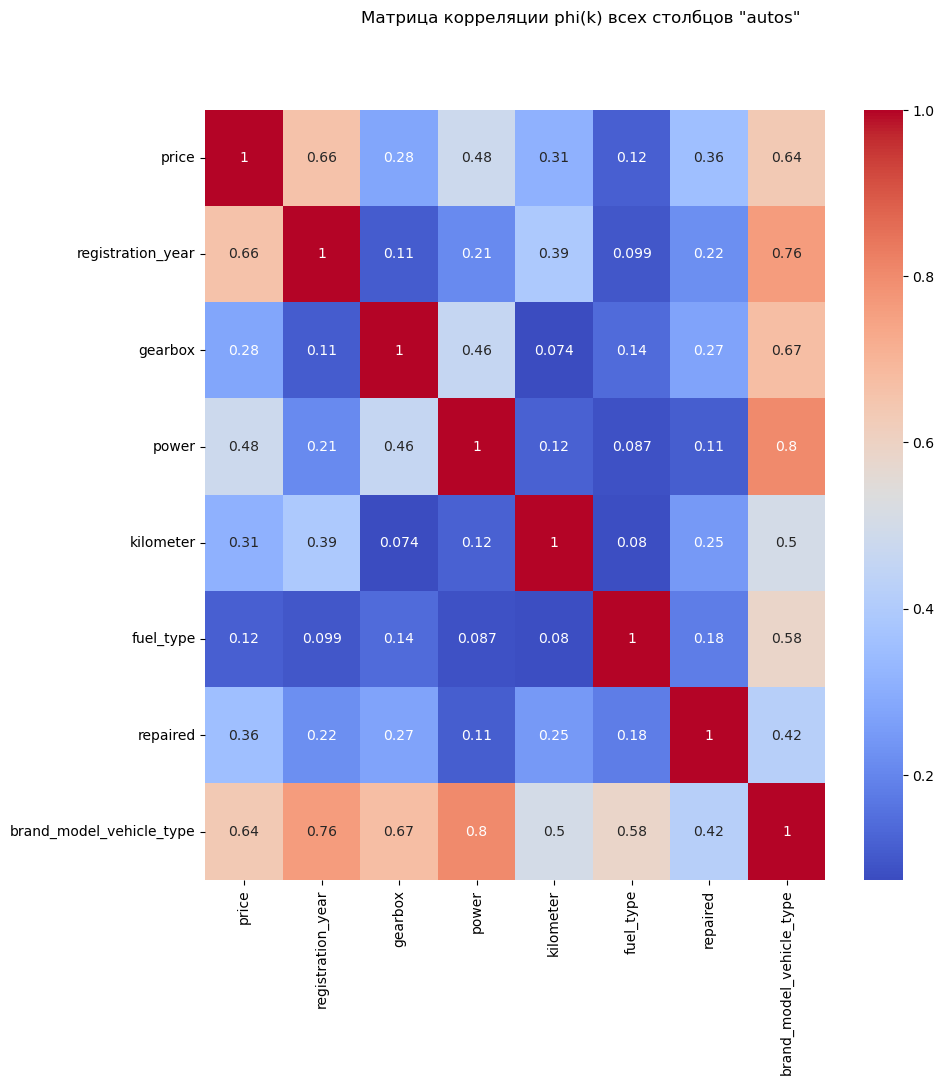

In [28]:
autos['brand_model_vehicle_type'] = autos['brand_model'] + '_' + autos['vehicle_type']
autos = autos.drop(columns=['brand_model', 'vehicle_type'])
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "autos"')
sns.heatmap(autos.phik_matrix(interval_cols = interval_cols), annot=True, cmap='coolwarm');

#### Вывод по подготовке данных

+ Данные загружены
+ Осуществлена предобработка данных
    + Переименованы столбцы
    + Удалены неинформативные признаки `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`
    + Удалены явные дубликаты
    + Заполнены пропущенные значения
+ Проведен исследовательский анализ данных
    + В данных обнаружено большое количество выбросов
    + Исключены строки по параметру "price" - цена (евро) с нулевым значением
    + Исключены строки по параметру "registration_year" - год регистрации автомобиля ранее 1960 года и более текущего года
    + Исключены строки по параметру "power" - мощность (л. с.) со значением до 40 и более 600 л.с
+ Проведен корреляционный анализ данных
    + Обнаружена прямая зависимость между входными параметрами, для исключения мультиколлениарности принято решение объеденить столбцы  `brand`, `model`, `vehicle_type` в один `brand_model_vehicle_type`, при этом его влияние на целевой признак `price` значительно phi(k) = 0.64, так же значительно влияние года регистрации машины `registration_year`, значение остальных параметров не значительно.

## 2. Обучение моделей

In [29]:
autos.head()

### 2.1. Подготовка выборки для обучения моделей

In [30]:
#cat_col_names = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
cat_col_names = ['gearbox', 'fuel_type', 'repaired', 'brand_model_vehicle_type']

num_col_names = ['registration_year', 'power', 'kilometer']
autos[cat_col_names] = autos[cat_col_names].astype('category')
autos.info()

autos.reset_index(drop= True, inplace= True)

RANDOM_STATE = 42
X = autos.drop(columns='price')
y = autos['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [31]:
autos.head()

### 2.2. Обучение модели — LightGBM

In [32]:
#%%time
start_time = time.time()

lgb_model = LGBMRegressor()
lgbm_params = {
               "n_estimators": [100, 120],
               "max_depth": [12, 14]
              }

lgbm_cv_model = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=5,
                             scoring ='neg_mean_squared_error',
                             n_jobs=-1,
                             verbose=1).fit(X_train, y_train)

end_time = time.time()
training_time_lgb = end_time - start_time

#print(f'Время обучения LightGBM: {(training_time_lgb):.2f} сек.')

print('-----')
rmse_lgb_v = (abs(lgbm_cv_model.best_score_)**0.5)
print(f'Метрика лучшей модели на на кросс-валидации:{rmse_lgb_v:.3f}')
print(f'Лучшие параметры модели: {lgbm_cv_model.best_params_}')
print('-----')

In [33]:
start_time = time.time()

model = LGBMRegressor(max_depth=14, n_estimators=120).fit(X_train, y_train)

end_time = time.time()
training_time_lgb = end_time - start_time
print(f'Время обучения LightGBM: {(training_time_lgb):.2f} сек.')

### 2.3. Обучение модели  Ridge - аналог LinearRegression с кодированными и масштабированными данными

In [34]:
#%%time
#start_time = time.time()
pipe_num = Pipeline([
    ('imp_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', StandardScaler()),

])

pipe_cat = Pipeline([
    ('imp_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])

linear_prep = ColumnTransformer([
    ('cat', pipe_cat, cat_col_names),
    ('num', pipe_num, num_col_names),
], remainder='passthrough')


lin_pipe = Pipeline([
    ('prep', linear_prep),
    ('model', Ridge())
])



param = {

}


rand_search_linear = RandomizedSearchCV(
    lin_pipe, 
    param, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    n_iter=10,
    verbose = 3
)

start_time = time.time()
rand_search_linear = rand_search_linear.fit(X_train, y_train)


end_time = time.time()
training_time_lr = end_time - start_time

#print(f'Время обучения LinearRegression: {(training_time_lr):.2f} сек.')

print('-----')
rmse_lr_v = (abs(rand_search_linear.best_score_))
print(f'Метрика лучшей модели на на кросс-валидации:{rmse_lr_v:.3f}')
print('-----')
print(f'Лучшие параметры модели: {rand_search_linear.best_params_}')
print('-----')

In [35]:
model = lin_pipe
start_time = time.time()
model = model.fit(X_train, y_train)
end_time = time.time()
training_time_lr = end_time - start_time

print(f'Время обучения LinearRegression: {(training_time_lr):.2f} сек.')

### 2.4. Обучение модели — CatBoostRegressor с использованием внутреннего кодировщика

In [36]:
%%time
start_time = time.time()

cbr_model = CatBoostRegressor()
cbrm_params = {
               'n_estimators': [100, 120],
               'max_depth': [12, 14],
               'cat_features': [cat_col_names]
              }

cbrm_cv_model = GridSearchCV(cbr_model,
                             cbrm_params,
                             cv=5,
                             scoring ='neg_mean_squared_error',
                             n_jobs=-1,
                             verbose=1).fit(X_train, y_train)

end_time = time.time()
training_time_cbr = end_time - start_time

#print(f'Время обучения CatBoostRegressor: {(training_time_cbr):.2f} сек.')

print('-----')
rmse_catboost_v = (abs(cbrm_cv_model.best_score_)**0.5)
print(f'Метрика лучшей модели на на кросс-валидации:{rmse_catboost_v:.3f}')
print('-----')
print(f'Лучшие параметры модели: {cbrm_cv_model.best_params_}')
print('-----')

In [37]:
start_time = time.time()

model = CatBoostRegressor(cat_features=['gearbox', 'fuel_type', 'repaired', 'brand_model_vehicle_type'], max_depth=12, n_estimators=120).fit(X_train, y_train)

end_time = time.time()
training_time_cbr = end_time - start_time
print(f'Время обучения CatBoostRegressor: {(training_time_cbr):.2f} сек.')

#### Вывод по обучению моделей

+ Подготовили данные, разделили их на тренировочную и тестовую
+ Для моделей без встроенного кодировщика провели кодирование и масштабирование данных
+ Обучили модель — LightGBM
+ Обучили модель — Ridge аналог LinearRegression
+ Обучили модель — CatBoostRegressor 
+ Получили показатели:
    + RMSE - среднеквадратичная ошибка
    + Т - время обучения моделей

## 3. Анализ моделей

### 3.1. Подготовка сводной таблицы

In [38]:
start_time = time.time()
lgbm_cv_model.predict(X_test)
end_time = time.time()
time_lgbm = round((end_time - start_time), 2)

In [39]:
start_time = time.time()
cbrm_cv_model.predict(X_test)
end_time = time.time()
time_cbrm = round((end_time - start_time), 2)

In [40]:
start_time = time.time()
rand_search_linear.predict(X_test)
end_time = time.time()
time_lr = round((end_time - start_time), 2)

In [41]:
results = pd.DataFrame({'Model': ['Linear_Regression', 'LightGBM_Regression', 'CatBoost_Regressor'],
                        'Training_Time_sec': [training_time_lr, training_time_lgb, training_time_cbr],
                        'Prediction_Time_sec': [time_lr, time_lgbm, time_cbrm],
                        'RMSE_Valid': [rmse_lr_v, rmse_lgb_v, rmse_catboost_v]})
results

Для заказчика важны:
+ качество предсказания (RMSE модели должен быть не более 2500);
+ скорость предсказания;
+ время обучения.

Отберем лучшую модель по этим параметрам.

### 3.2. "Качество модели"
+ Исключим модели у которых RMSE более 2500
+ Отсортируем по возрастающей

In [42]:
results = results[results['RMSE_Valid']<2500].sort_values('RMSE_Valid')
results

Более качественная модель `LightGBM_Regression` значение RMSE (среднеквадратичная ошибка)  = 1648.

### 3.3. "Скорость предсказания"
+ Отсортируем по возрастающей

In [43]:
results = results.sort_values('Prediction_Time_sec')
results

Обе модели по скорости предсказания менее одной секунды, но модель `CatBoost_Regressor` предсказывает быстрее чем модель `LightGBM_Regression`. 

### 3.4. "Скорость обучения"
+ Отсортируем по возрастающей

In [44]:
results = results.sort_values('Training_Time_sec')
results

Быстрее обучается модель `LightGBM_Regression`.

#### Вывод по анализу моделей
Самой точной моделью является `LightGBM_Regression`.\
Быстрее всех предсказывает `CatBoost_Regressor`.\
Быстрее всех обучается `LightGBM_Regression`

Оптимальным решением будет выбрать модель `LightGBM_Regression`.

Проверим соответствие модели требованиям на тестовых данных.

In [45]:
rmse_test = mean_squared_error(y_test, lgbm_cv_model.predict(X_test), squared=False)
print("RMSE LGBMRegressor на валидации: %.2f" % rmse_lgb_v)
print("RMSE LGBMRegressor на тестовой выборке: %.2f" % rmse_test)
print(f'Потеря качества модели LGBMRegressor на тестовой выборке по отношению к валидационной: {((rmse_test - rmse_lgb_v)/rmse_lgb_v*100):.3f} %' )

Расчитанный параметр RMSE на тестовых данных нас устраивает.

## 4. Вывод

+ Проведена подготовка данных
+ Предобработаны данные
+ Проведен исследовательский анализ данных
+ Проведен корреляционный анализ данных, исключена мультиколлениарность
+ Проведена подготовка данных
+ Обучена модель — `LightGBM`
+ Обучена модель — `LinearRegression` с кодированными и масштабированными данными
+ Обучена модель — `CatBoostRegressor` 
+ Проведен анализ обученных моделей
+ Отобрана лучшая модель (`LightGBM`) и проверена на тестовой выборке

#### Рекомендации для заказчика

1. Оптимальным решением будет выбрать модель `LightGBM`
2. Модель будет предсказывать цену автомобиля с максимальной точностью RMSE = 1648.63 и скоростью 0,52 сек. Настройку обучения, можно осуществлять раз в день, по новым поступившим данным, в связи с большим временем обучения модели.